In [1]:
import os
import pickle

import torch as th 
import numpy as np
import matplotlib.pyplot as plt
import torchvision;

from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from scripts import *

In [2]:
# input
# model_checkpoint = best model path
# save_path = save path
model_checkpoint = "experiments/dcgan_experiments/lightning_logs/version_2/checkpoints/epoch=974.ckpt"
save_path = "experiments/ganspace/dcgan_experiments_version_2_epoch=974"

# optional
# n_samples = batch size for incremental PCA
# n_time = number of batches
n_samples = 5000
n_time = 5

In [3]:
model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()
1

1

In [4]:
@th.no_grad()
def get_linear_act(model, n_samples=10000):
    """Returns latent vector and linear layer activations"""
    z = th.normal(0, 1, size=(n_samples, model.generator.latent_dim), device=model.device)
    l = model.generator.l1(z)
    X = np.squeeze(l.detach().cpu().numpy())
    y = np.squeeze(z.detach().cpu().numpy())    
    return X, y

In [5]:
pca_path = os.path.join(save_path, "pca.pkl")


if not os.path.exists(pca_path):
    pca = IncrementalPCA(n_components=4096)
    os.makedirs(os.path.join(save_path), exist_ok=True)

    for i in range(n_time):
        print("Iteration - ", i+1)
        X, y = get_linear_act(model, n_samples)

        # save the data
        np.save(os.path.join(save_path, f"y{i+1}.npy"), y)
        np.save(os.path.join(save_path, f"X{i+1}.npy"), X)

        pca.partial_fit(X)

    # save the pca
    f = open(pca_path, "wb")
    pickle.dump(pca, f)
    f.close()
else:
    f = open(pca_path, 'rb')
    pca = pickle.load(f)
    f.close()

In [6]:
# load dataset
X = np.concatenate([np.load(os.path.join(save_path, f"X{i+1}.npy")) for i in range(n_time)], axis=0)
y = np.concatenate([np.load(os.path.join(save_path, f"y{i+1}.npy")) for i in range(n_time)], axis=0)

# information gain
tmp = np.cumsum(pca.explained_variance_ratio_)
variance_90 = np.where(tmp >= 0.9)[0][0]
print("Varience 90% :", variance_90)

# reconstruction
X_pca = (X - pca.mean_).dot(pca.components_[:variance_90].T) 

# resonctruction error
X_rec = X_pca.dot(pca.components_[:variance_90]) + pca.mean_
print("Reconstruction Error : ", np.linalg.norm(X_rec - X) / len(X))

Varience 90% : 30
Reconstruction Error :  0.05757167617569942


In [33]:
tmp = {"E" : pca.components_[:variance_90], 
       "mu" : pca.mean_, 
       "stds" : [x.std() for x in X_pca[:, :variance_90].T]}
np.save(os.path.join(save_path, "pca_generator.npy"), tmp)

In [45]:
@th.no_grad()
def explore_pca(gen, Z, idx, ratios):
    """Exploring PCA directions"""
    
    imgs = []
    for z in Z:
        for ratio in ratios:
            z[idx] = ratio
            img = th.squeeze(gen(z))
            imgs.append(img)
            
    grid = torchvision.utils.make_grid(imgs, nrow=len(ratios), normalize=True, pad_value=1)
    return grid

In [46]:
if not os.path.exists(os.path.join(save_path, "pca_generator.npy")):
    E = pca.components_[:variance_90], 
    mu = pca.mean_
    stds = [x.std() for x in X_pca[:, :variance_90].T]
else:
    tmp = np.load(os.path.join(save_path, "pca_generator.npy"), allow_pickle=True).item()
    E = tmp["E"]
    mu = tmp["mu"]
    stds = tmp["stds"]

In [47]:
E = th.tensor(E, device=model.device, dtype=Z.dtype)
mu = th.tensor(mu, device=model.device, dtype=Z.dtype)
gen = PCAGenerator(model.generator, E, mu)

In [87]:
Z = th.tensor([[np.random.normal(0, scale) for scale in stds] for _ in range(5)], device=model.device)
for z in Z:
    z[0] = max(z[0], 11.8467328) if z[0] > 0 else min(z[0], -11.8467328)

([], [])

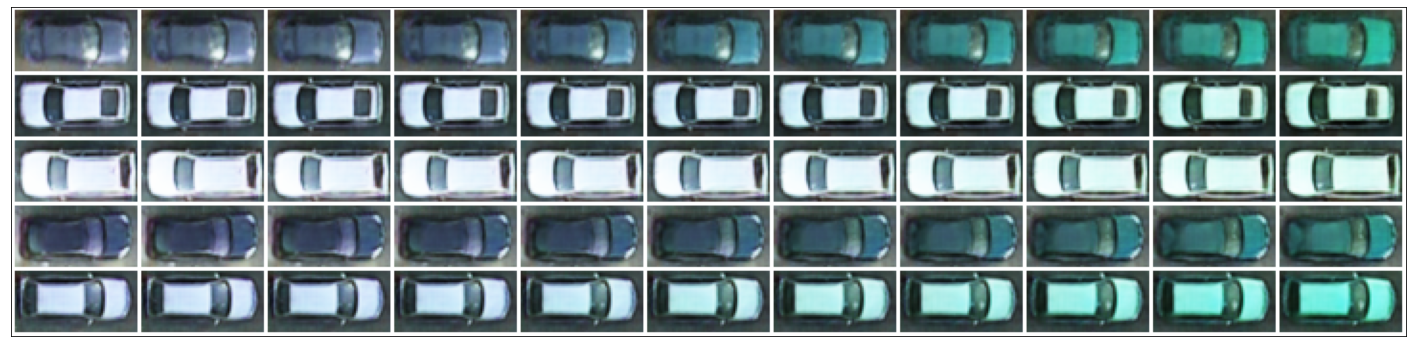

In [88]:
# %matplotlib inliine
i = 15
scale = 3*stds[i]
scale2 = 1
ratios = np.linspace(-scale * scale2, scale * scale2, 11)
grid = explore_pca(gen, Z.clone(), i, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

In [ ]:
# input
model_checkpoint = "experiments/dcgan_experiments/lightning_logs/version_2/checkpoints/epoch=974.ckpt"
save_path = "experiments/ganspace/dcgan_experiments_version_2_epoch=974"

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim
i = 0, +/- 3*std*0.3, orientation of the car - look right + look left
i = 1, +/- 3*std , - white car + dark green car
i = 2, +/- 3*std*0.75, converts car sedan or hatchback depends (where it faces it become sedan and other direction becomes hatchback) 
i = 3, +/- 3*std*0.75, moves car  - up + down
i = 4,
i = 5, 
i = 6, something to do with lighting
i = 7, +/- 3*std, - makes car pinker + makes car bluer
i = 8, something to do with color and adding top window
i = 9, something to do with lighting, coloring and shape
i = 10, +/- 3*std*2, - bright spots on top, + bright spots on bottom
i = 11, +/- 3*std, - makes car thicker/larger, + makeds car thinner/smaller
i = 12, +/-3*std, - brigther image + darker image
i = 13, +/-3*std - makes car shorter and thicker + make car longer and thiner
i = 14, something to do with deformation, little bit coloring and lighting
i = 15, +/- 3*std*2, - makes car purpler + make car turquoiser
i = 16, +/- 3*std*3, - makes top part brighter + makes bottom part brighter
i = 17, +/- 3*std*3, - bends/rotates it counter clock wise, + bends/rotates it clock wise
i = 18, +/- 3*std*2, - bends/rotates it clock wise, + bends/rotates it counter clock wise (image quality better than 17)
i = 19, +/- 3*std - makes right side rounder + makes right side rectangular (car orientation looks like important)
i = 20, (0, 3*std*4), make car rectangular
i = 21, (0, 3*std*5), add car lamps on right and makes right side flat
i = 22,
i = 23, +/- 3*std*3, - makes right side smaller + makes right side wider
i = 24, +/- 3*std*5, - bends car upwards + bends car downwards
i = 25, +/- 3*std*5, - bends car downwards + bends car upwards
i = 26,
i = 27,
i = 28,
i = 29,

In [ ]:
import matplotlib

# save plots for latex
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


# PLOT 1: Varience Percentage %
information_gain = 100*pca.explained_variance_ratio_[:variance_90]
xticks = np.arange(2, 2*variance_90+2, 2)

plt.figure(figsize=(8, 4))
plt.bar(xticks, information_gain, width=1.4)
plt.xticks(xticks, 1 + np.arange(variance_90), fontsize=16, rotation=90)
plt.yticks(fontsize=16)

plt.ylabel("Variance Percentage (%)", fontsize=18)
plt.xlabel("Principal Components", fontsize=18)

plt.grid(axis='y')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(save_path, "pca_variance_percentage.pgf"))

# PLOT 2: PCA distribution
fig=plt.figure(figsize=(15, 15))
from scipy.stats import norm

# needs to set beforehand
columns = 6
rows = 5
for i in range(1, columns*rows +1):
    dim = X_pca[:, i-1]
    fig.add_subplot(rows, columns, i)
    
    # data dist
    plt.hist(dim, bins=50, density=True, alpha=0.6)
    
    # fit gaus
    mu, std = dim.mean(), dim.std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k--', linewidth=2)
    
    plt.title("Eigen Dim %d" % i, fontsize=22)
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()
plt.savefig(os.path.join(save_path, "eigen_dim_distributions.pgf"))

In [ ]:
# shape
i = [23, 20, 11, 5, 9]

# lighting
i = [10, 12, 16, 6, 14, 9]

# deformations
i = [17, 18, 25, 24, 14]

# color 
i = [7, 15, 8 , 14, 9]

# car type
i = [1, 2]


In [ ]:
model.cuda()
E = th.tensor(comp, device=model.device, dtype=th.float32)
mu = th.tensor(mean, device=model.device, dtype=th.float32)
pca_generator = PCAGenerator(model.generator, E, mu)


indexes = {#0:(3*0.3, 3*0.3), 
          1:(3, 3), 
          2:(3*0.75, 3*0.75), 
          3:(3*0.75, 3*0.75), 
          5:(3*0.75, 3*0.75), 
          7:(3, 3),
          10:(3*2, 3*2),
          11:(3, 3),
          12:(3, 3),
          15:(6, 6),
          16:(9, 9),
          17:(9, 9),
          18 : (6, 6),
          20 : (0, 12),
          21 : (0, 15),
          23 : (9,9 ),
          24 : (0, 15),
          25 : (0, 15)
          }

groups = {
         "shape" : [23, 20, 11, 5, 9],
         "lighting" : [10, 12, 16, 6, 14, 9],
         "deformations" : [17, 18, 25, 24, 14],
         "color" : [7, 15, 8 , 14, 9], 
         "car_type" : [1, 2],
         "nothing" : []}

unknown = [4, 22, 26, 27, 28, 29]
truncate = True
import os

for key in groups:
    dims = groups[key]
    
    path = os.path.join(save_path, "truncated" if truncate else "nontruncated", f"{key}_disabled")
    os.makedirs(path, exist_ok=True)


    with th.no_grad():
        for i in range(10):
            points = [[np.random.normal(0, scale) for scale in stds] for _ in range(1000)]
            points = th.tensor(points, device=model.device)
            
            if dims:
                points[:, dims] = 0
            if truncate:
                points[:, unknown] = 0
                for point in points:
                    point[0] = max(point[0], stds[0]*3*0.6) if point[0] > 0 else min(point[0], -stds[0]*3*0.6)
                    
                    for idx in indexes:
                        s1, s2 = indexes[idx]
                        point[idx] = min(point[idx], stds[idx]*s2) if point[idx] > 0 else max(point[idx], -stds[idx]*s1)
            imgs = pca_generator(points)
                             
            for j, img in enumerate(imgs):
                torchvision.utils.save_image(img, os.path.join(path, f"{i*1000 + j}.png"), normalize=True, range=(-1, 1))

In [ ]:
idx = [] # [6, 8, 9, 13, 14, 19, 22, 26, 27, 28, 29]

indexes = {0:(3*0.3, 3*0.3), 
          1:(3, 3), 
          2:(3*0.75, 3*0.75), 
          3:(3*0.75, 3*0.75), 
          4:(3, 3), 
          5:(3*0.75, 3*0.75), 
          7:(3, 3),
          10:(3*2, 3*2),
          11:(3, 3),
          12:(3, 3),
          15:(3*2, 3*2),
          16:(9, 9),
          17:(9, 9),
          18 : (6, 6),
          20 : (0, 3*4),
          21 : (0, 3*5),
          23 : (9,9 ),
          24 : (0, 15),
          25 : (0, 15)
          }
# model.cuda()
E = th.tensor(comp, device=model.device, dtype=th.float32)
mu = th.tensor(mean, device=model.device, dtype=th.float32)
pca_generator = PCAGenerator(model.generator, E, mu)
scales = stds
imgs = []

with th.no_grad():    
    point = th.tensor([np.random.normal(0, scale) for scale in scales], device=model.device)
    point[0] = max(point[0], 11.8467328 / 1) if point[0] > 0 else min(point[0], -11.8467328 / 1)
    # point[20:] = 0 # 12

    #l_rec = point.matmul(E) + mu
    #l_rec = l_rec.view(1,  model.generator.init_channels,
    #        model.generator.init_height,  model.generator.init_width)
    #img =th.squeeze(model.generator.conv_blocks(l_rec))
    img = th.squeeze(pca_generator(point))
    imgs.append(img)

    for _ in range(19):
        point2 = point.clone()
        for idx_ in indexes:
            if idx_ == 0:
                continue
            if np.random.uniform(0, 1) > 0.25:
                a, b = indexes[idx_]
                point2[idx_] = np.random.uniform(-a*scales[idx_]/2, b*scales[idx_]/2)
        for idx_ in idx:
            point2[idx_] = 0

        l_rec = point2.matmul(E) + mu
        l_rec = l_rec.view(1,  model.generator.init_channels,
                model.generator.init_height,  model.generator.init_width)
        img = th.squeeze(model.generator.conv_blocks(l_rec))
        imgs.append(img)
    
grid = torchvision.utils.make_grid(imgs, nrow=5, normalize=True, pad_value=1)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(25, 15))
plt.xticks([])
plt.yticks([])
plt.imshow(grid)

In [ ]:
idx = [9, 13]

indexes = {0:(3*0.3, 3*0.3), 
          1:(3, 3), 
          2:(1.5, 1.5), 
          3:(3*0.75, 3*0.75), 
          4:(3, 0), 
          5:(3, 3), 
          7:(3, 3),
          8:(3, 3),
          10:(3*1.75, 3*1.75),
          11:(3, 3),
          12:(3*1.5, 0),
          14:(6, 6),
         15:(3*1.5, 3*1.5),
         16:(9, 9),
         17:(9, 9),
         18 : (6, 6),
         19 : (9, 9)}
# model.cuda()
E = th.tensor(comp, device=model.device, dtype=th.float32)
mu = th.tensor(mean, device=model.device, dtype=th.float32)
scales = stds
imgs = []

with th.no_grad():    
    point = th.tensor([np.random.normal(0, scale) for scale in scales], device=model.device)
    point[0] = max(point[0], 11.8467328 / 1) if point[0] > 0 else min(point[0], -11.8467328 / 1)
    # point[20:] = 0 # 12

    l_rec = point.matmul(E) + mu
    l_rec = l_rec.view(1,  model.generator.init_channels,
            model.generator.init_height,  model.generator.init_width)
    img =th.squeeze(model.generator.conv_blocks(l_rec))
    imgs.append(img)

    for _ in range(19):
        point2 = point.clone()
        for idx_ in indexes:
            if idx_ == 0:
                continue
            if np.random.uniform(0, 1) > 0.5:
                a, b = indexes[idx_]
                point2[idx_] = np.random.uniform(-a*scales[idx_]/2, b*scales[idx_]/2)
        for idx_ in idx:
            point2[idx_] = 0

        l_rec = point2.matmul(E) + mu
        l_rec = l_rec.view(1,  model.generator.init_channels,
                model.generator.init_height,  model.generator.init_width)
        img = th.squeeze(model.generator.conv_blocks(l_rec))
        imgs.append(img)
    
grid = torchvision.utils.make_grid(imgs, nrow=5, normalize=True)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(25, 15))
plt.xticks([])
plt.yticks([])
plt.imshow(grid)

In [ ]:
img_dim = model.hparams.img_dim[1:]
hue = [-0.1, 0.1]
contrast = [1, 1.25]
brightness = [1, 2]
data_augs = [
    # no dat aug
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5], [0.5])]),
    # horizontal flip only
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.Normalize([0.5], [0.5])]),
    # horizontal flip + hue
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.ColorJitter(hue=hue),
                        transforms.Normalize([0.5], [0.5])]),
    # horizontal flip + hue + contrast
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.ColorJitter(hue=hue, contrast=contrast),
                        transforms.Normalize([0.5], [0.5])]),
    # horizontal flip + hue + contrast + brightness
    transforms.Compose([transforms.Resize(img_dim),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.ColorJitter(
                            hue=hue, brightness=brightness, contrast=contrast),
                        transforms.Normalize([0.5], [0.5])]),
]

potsdam_dir = "../potsdam_data/potsdam_cars_corrected"
# data loaders
i = 3
n_samples = 1024
dataset = ImageFolder(potsdam_dir, transform=data_augs[i])
potsdam_cars_dataloader = DataLoader(dataset, batch_size=4300, shuffle=True, num_workers=4)
real,_ = next(iter(potsdam_cars_dataloader))
act1 = np.squeeze(vgg16_get_activation_maps(
                real, layer_idx=33, device="cuda:0", normalize_range=(-1, 1)).numpy())

In [ ]:
with th.no_grad():
    points = []
    for _ in range(n_samples):
        point = [np.random.normal(0, scale) for scale in stds]
        #point[0] = max(point[0], 11.8467328 / 2) if point[0] > 0 else min(point[0], -11.8467328 / 2)
        point[0] = 11.8467328 if point[0] > 0 else -11.8467328
        points.append(point)
    points = th.tensor(points, device=model.device)
    l_rec = points.matmul(E) + mu
    l_rec = l_rec.view(n_samples,  model.generator.init_channels,
            model.generator.init_height,  model.generator.init_width)
    fake =th.squeeze(model.generator.conv_blocks(l_rec))

act2 = np.squeeze(vgg16_get_activation_maps(
                fake,  layer_idx=33, device="cuda:0", normalize_range=(-1, 1)).numpy())

fid_score(act1, act2,  n_cases=n_samples,skip_vgg=True, memorized_fid=False)

In [ ]:
# norms inverse, replace inf values with 0
act1_norm = np.expand_dims(np.linalg.norm(act1, axis=1), 1)
act2_norm = np.expand_dims(np.linalg.norm(act2, axis=1), 1)
norms_inverse = 1 / (act2_norm.dot(act1_norm.T))

norms_inverse[np.isinf(norms_inverse)] = 0

# cos distance between two activations
cos_distances = (1 - norms_inverse*act2.dot(act1.T))
cos_distance = cos_distances.min(axis=1)  # min for each row
d = np.mean(cos_distance)

plt.hist(cos_distance)
plt.show()

jj = np.random.choice(len(fake), 50, replace=False)
#jj = np.argsort(cos_distance)[-50:]
#jj = np.argsort(cos_distance)[:50]
n = 10
imgs = []
for j in jj:
    idx = np.argsort(cos_distances[j])
    
    imgs.append(fake[j])
    for idx_ in idx[:n]:
        imgs.append(real[idx_])
        
grid = torchvision.utils.make_grid(imgs, nrow=n+1, normalize=True)
torchvision.utils.save_image(grid, "dcgan_random.png")

In [ ]:
real_mean = (real.mean(axis=0).detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2
fake_mean = (fake.mean(axis=0).detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.imshow(real_mean)
plt.subplot(2, 1, 2)
plt.imshow(fake_mean)
plt.tight_layout()

np.linalg.norm(real_mean - fake_mean)

In [ ]:
model_checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler/lightning_logs/version_0/checkpoints/epoch=899.ckpt"
save_path = "experiments/ganspace/dcgan_disc_double_params_padding_reflect_lr_scheduler_epoch=899"

# dim 1 : [-s, s] : white car
# dim 2 : [-s, s] : white van or green car
# dim 3 : [-s, s] : makes car longer but results get worse
# dim 4 : [-s/2, s/2] : move cars up and down
# dim 5 : [-s, 0] : adds top window
# dim 6 : [-s, s] : -s : makes car thicker and higlights its surrounding, s : makes car brighter color
# dim 7 : [-s, s] : -s : bright spots on right, s : bright spots on left
# dim 8 : [-s, s] : -s : makes it red/orange, s: makes it blue/purple
# dim 9 : [-s, s] : -s : makes it blue/pruple, s: makes it red/pink (looks nicer than dim 8)
# dim 10: [] : keep 0
# dim 11: [-s, s] : -s : birght spots on top, s: bright spots on bottom
# dim 12: [-s*0.75, s*0.5] : -s : makes image birghter, s : makes image darker
# dim 13: [-s*0.75: 0] : -s : makes car shorter
# dim 14 : keep 0
# dim 15 : [-s, s] : -s : bright spots on right, s : darker right
# dim 16 : [-s*0.75, s] : -s : makes car longer, s:makes car shorter
# dim 17 : [-s*0.75, s*0.75] : -s : makes bottom darker, s: makes bottom brighter
# dim 18 : [-s, s] : -s bends/rotates it counter clock wise, s : bends/rotates it clock wise
# dim 19 : [-s, s] : -s makes carish green, s: makes car redish and highlights the car lamps
# dim 20 : [-s , s] : -s : add car lamps on right, s : add car lamps on left (car orientation is important)
# dim 21 : 
# dim 22 : 
# dim 23 : 
# dim 24 : 
# dim 25 : [0, s] : s : bends the left part of the car
# dim 26 : 
# dim 27 :
# dim 28 :
# dim 29 :

In [ ]:
i = 3
scale = np.sqrt(pca.singular_values_)[i] * 0.5
ratios = np.linspace(-scale * 1, scale * 1, 11)
grid = explore_principle_direction_pca(i, E, mu, model.generator, zs, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)
plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

In [ ]:
ratios = np.linspace(-scale * 1, scale * 1, 11)
grid = explore_principle_direction(i, U, model, zs, ratios)
grid = grid.detach().cpu().numpy().transpose(1, 2, 0)

plt.figure(figsize=(25, 15))
plt.imshow(grid)
plt.xticks([])
plt.yticks([])

In [ ]:
E = th.tensor(comp, device=model.device, dtype=th.float32)
mu = th.tensor(mean, device=model.device, dtype=th.float32)
scales = stds

# point = th.tensor([np.random.uniform(-scale/2, scale/2) for scale in scales], device=model.device)
point = th.tensor([np.random.normal(0, scale) for scale in scales], device=model.device)

point[0] = -1*-11.8467328
#point[13] = 0


l_rec = point.matmul(E) + mu
l_rec = l_rec.view(1,  model.generator.init_channels,
        model.generator.init_height,  model.generator.init_width)
img = th.squeeze(model.generator.conv_blocks(l_rec))
img = (img.detach().cpu().numpy().transpose(1, 2, 0 ) + 1) / 2
plt.imshow(img)

In [ ]:
point

In [ ]:
z = th.normal(0, 1, size=(1, model.generator.latent_dim), device=model.device) 
img = th.squeeze(model(z))
img = (img.detach().cpu().numpy().transpose(1, 2, 0 ) + 1) / 2
plt.imshow(img)

In [ ]:
np.sqrt(pca.singular_values_[50]), std

In [ ]:
zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
#zs = th.zeros((15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

In [ ]:
# model

model_checkpoint = "experiments/dcgan_disc_double_params_padding_reflect_lr_scheduler/lightning_logs/version_0/checkpoints/epoch=899.ckpt"
save_path = "experiments/ganspace/dcgan_disc_double_params_padding_reflect_lr_scheduler_epoch=899"

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim
i = 0, +/- 3*std*0.3, orientation of the car - look right + look left
i = 1, +/- 3*std, - van, + brown car
i = 2, +/- 3*std*0.5, 
i = 3, +/- 3*std*0.75, moves car up/down
i = 4, (-3*std, 0), adds top window
i = 5, (-3*std*0.75, 0) : makes car thicker and higlights its surrounding and adds strips on top
i = 6, 
i = 7, +/- 3*std, - makes car reddish and thicker, + makes car blueish and thinner
i = 8, +/- 3*std, - makes car blueish, + makes car reddish and add bright spot
i = 9, +/- 3*std, keep zero, doesn't have any results
i = 10, +/- 3*std*1.75, - bright spots on top, + bright spots on bottom
i = 11, +/- 3*std, - bright background, + dark background
i = 12, -3*std*1.5, - makes car shorter and brighter
i = 13, +/- 3*std, keep zero, doesn't have any results
i = 14, +/- 3*std*2, - bright spot and window on the top, + darker right
i = 15, +/- 3*std*1.5, - makes car longer, + makes car shorter
i = 16, +/- 3*std*3, idk something with light
i = 17, +/- 3*std*3, - bends/rotates it counter clock wise, + bends/rotates it clock wise
i = 18, +/- 3*std*2, - makes car green, + makes car redish and higlights the lamps
i = 19, +/- 3*std*3, - add car lamps on right and makes right side flat, + add car lamps on left and makes left side flat (car orientation is important)
i = 20, 
i = 21, +/- 3*std*4, - makes car gren, + makes car pink
i = 22,
i = 23, 
i = 24, 
i = 25,
i = 26,
i = 27,

In [ ]:
# input
model_checkpoint = "experiments/dcgan_resnet/lightning_logs/version_0/checkpoints/epoch=524.ckpt"
save_path = "experiments/ganspace/dcgan_resnet_version_0_epoch=524"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 


dims_ = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19, 20]
ratios_ = [[-50, 50], [-30, 30], 
          [-50, 50], [-50, 50], 
          [-50, 0], [0, 50], 
          [-50, 0], [-50, 50], 
          [0, 40], [-40 , 40], 
          [0, 50], [-50, 50], 
          [-70, 0], [-50, 50]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))


In [ ]:
# input
model_checkpoint = "experiments/big_image/lightning_logs/version_0/checkpoints/epoch=449.ckpt"
save_path = "experiments/ganspace/big_image_version_0_epoch=449"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 0 : ratio [-50, 50] : make cars white and them left or right
# dim 1 : ratio [-30, 30] : makes cars white van or green
# dim 5 : ratio [-50, 50] : car becomes red or blue
# dim 6 : ratio [-50, 50] : makes car blue or redish with strips on top
# dim 7 : ratio [-50, 0] : adds bright spot in right side
# dim 8 : ratio [0, 50] : adds bright spot in left side
# dim 9 : ratio [-50, 0] : adds bright spot in left side
# dim 10 : ratio [-50, 50] : makes image brighter or darker
# dim 12 : ratio  [0, 40] : tries to add roof
# dim 11 : ratio [-40, 40] : makes bottom part brighter or top part darker
# dim 14 : ratio [0, 50] : makes car longer
# dim 15 : ratio [-50, 50] : adds car light bottom left or bends it to bottom right
# dim 19 : ratio [-70, 0] : bends it to bottom left
# dim 20 : ratio [-50, 50] : makes car smaller or rotates the car


dims_ = [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 19, 20]
ratios_ = [[-50, 50], [-30, 30], 
          [-50, 50], [-50, 50], 
          [-50, 0], [0, 50], 
          [-50, 0], [-50, 50], 
          [0, 40], [-40 , 40], 
          [0, 50], [-50, 50], 
          [-70, 0], [-50, 50]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))


In [ ]:
# input
model_checkpoint = "experiments/dataaug/lightning_logs/version_1/checkpoints/epoch=774.ckpt"
save_path = "experiments/ganspace/dataaug_bn_default_epoch=774"

model = GAN.load_from_checkpoint(model_checkpoint)
model.eval()

# optional
n_samples = 5000
n_time = 5
layer = "linear"

# dim 0 : ratio [-50, 50] : make cars white and them left or right
# dim 1 : ratio [-20, 20] : makes cars white van or green
# dim 3 : ratio [-20, 20] : moves car from top to bottom
# dim 5 : ratio [-40, 40] : car becomes red or gets strips on top
# dim 6 : ratio [-30, 0] : makes car blue
# dim 9 : ratio [-20, 20] : makes image brighter or darker
# dim 10 : ratio [-40, 0] : adds bright spot and makes car green
# dim 11 : ratio [-40, 40] : makes image darker and green or blue and bright spot on bottom
# dim 13 : ratio [-30, 30] : makes image red or green
# dim 14 : ratio [-60, 0] : adds car light front and back
# dim 16 : ratio [-60, 60] : lighting direction
# dim 17 : ratio [-50, 50] : changes the aspect ratio of car + lighting on front or back
# dim 20 : ratio [-40, 40] : twists the car and rotates little bit and adds light spot
# dim 25 : ratio [-70, 70] : makes car green or red and add bright spot on left or right
# dim 44 : ratio [-100, 0] : bending the car

dims_ = [0, 1, 3, 5, 6, 9, 10, 11, 13, 14, 16, 17, 20, 25, 44]
ratios = [[-50, 50], [-20, 20], 
          [-20, 20], [-40, 40], 
          [-30, 0], [-20, 20], 
          [-40, 0], [-40, 40], 
          [-30, 30], [-60 , 0], 
          [-60, 60], [-50, 50], 
          [-40, 40], [-70, 70], 
          [-100, 0]]

np.save(os.path.join(save_path, layer, "important_dims.npy"), {"dims" : dims_, "ratios" : ratios_})

zs = th.zeros((1, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grids.append(explore_principle_direction(d, U, model, zs, ratios))
    
grid = torchvision.utils.make_grid(grids, nrow=1, normalize=True)
torchvision.utils.save_image(grid, os.path.join(save_path, layer, "pca_directions.png"))

zs = th.normal(0, 0.75, size=(15, model.generator.latent_dim), device=model.device) 
U = th.tensor(reg.coef_, device=model.device, dtype=zs.dtype)

grids = []
for d, (down, up) in zip(dims_, ratios_):
    ratios = np.linspace(down, up, 11)
    grid = explore_principle_direction(d, U, model, zs, ratios)
    torchvision.utils.save_image(grid, os.path.join(save_path, layer, f"pca_dim={d}.png"))
